In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# ==========================
# 1. Load Cleaned Data
# ==========================

train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_train.csv", index_col=0)
dev_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_dev.csv", index_col=0)
test_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/cleaning_test.csv", index_col=0)

train_df['date'] = pd.to_datetime(train_df['date'])
dev_df['date'] = pd.to_datetime(dev_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

print("Date Range for train data: ", train_df.date.min(), "to ", train_df.date.max())
print("Date Range for dev data: ", dev_df.date.min(), "to ", dev_df.date.max())
print("Date Range for test data: " , test_df.date.min(), "to ", test_df.date.max())

Date Range for train data:  2012-03-31 00:00:00 to  2019-12-31 00:00:00
Date Range for dev data:  2020-01-31 00:00:00 to  2021-12-31 00:00:00
Date Range for test data:  2022-01-31 00:00:00 to  2023-12-31 00:00:00


In [3]:
# ==========================
# 2. Date features
# ==========================
def add_date_features(df):
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month

    # Reorder the dataframe
    df.insert(1, 'year', df.pop("year"))
    df.insert(2, 'quarter', df.pop("quarter"))
    df.insert(3, 'month', df.pop("month"))

    return df
 
train_df = add_date_features(train_df)
dev_df = add_date_features(dev_df)
test_df = add_date_features(test_df)   

In [4]:
train_df.head(2)

,date,year,quarter,month,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,median_dom,avg_sale_to_list,sold_above_list,off_market_in_two_weeks,city,zipcode,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Total Labor Force,Unemployed Population,Total School Age Population,Total School Enrollment,Median Commute Time,price,city_full,lat,lng
0,2012-03-31,2012,1,3,46550.0,217450.0,31.813674,110.183666,14.0,23.0,44.0,64.0,59.5,0.943662,0.142857,0.043478,ATL,30002,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,3171.0,460.0,5408.0,5408.0,2492.0,200773.999557,Atlanta-Sandy Springs-Roswell,33.7338,-84.3922
1,2012-03-31,2012,1,3,200000.0,7500.0,104.931794,79.265873,1.0,1.0,1.0,2.0,290.0,0.909091,0.000000,0.000000,PGH,15469,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1171.0,52.0,2376.0,2376.0,1018.0,105863.681174,Pittsburgh,40.4744,-79.8632


In [5]:
# ==========================
# 3. Frequency Encoding (Zipcode)
# ==========================

zipcode_counts = train_df.zipcode.value_counts()

# Using train data counts to transform the dev and test datasets

train_df["zipcode_freq"] = train_df["zipcode"].map(zipcode_counts)
dev_df["zipcode_freq"] = dev_df["zipcode"].map(zipcode_counts).fillna(0)
test_df["zipcode_freq"] = test_df["zipcode"].map(zipcode_counts).fillna(0)

"""
Note:

On train data, we build the frequency dictionary (zipcode_counts)
On dev and test set, we never compute newer counts, we just look up in the existing dictionary and if we don't get any value, we fill it with 0.
"""

"\nNote:\n\nOn train data, we build the frequency dictionary (zipcode_counts)\nOn dev and test set, we never compute newer counts, we just look up in the existing dictionary and if we don't get any value, we fill it with 0.\n"

In [6]:
train_df[['zipcode', 'zipcode_freq']].head()

,zipcode,zipcode_freq
0,30002,94
1,15469,87
2,15468,89
3,15466,86
4,15464,86


In [7]:
# ==========================
# 4. Target Encoding (City)
# ==========================

te = TargetEncoder(cols=["city_full"])

train_df["city_encoded"] = te.fit_transform(train_df["city_full"], train_df["price"])
dev_df["city_encoded"] = te.transform(dev_df["city_full"])
test_df["city_encoded"] = te.transform(test_df["city_full"])

print(train_df[['city_full', 'city_encoded']].head())

                       city_full   city_encoded
0  Atlanta-Sandy Springs-Roswell  192580.125925
1                     Pittsburgh  131539.870286
2                     Pittsburgh  131539.870286
3                     Pittsburgh  131539.870286
4                     Pittsburgh  131539.870286


In [ ]:
# ==========================
# 5. Drop Unused Columns
# ==========================

drop_cols = ["date", "city_full", "city", "zipcode", "median_sale_price"]
train_df.drop(columns=drop_cols, inplace=True)
dev_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Dropping "median_sale_price" as it is directly correlated with the target

In [20]:
assert train_df["Total School Enrollment"].all() == train_df["Total School Age Population"].all()
assert dev_df["Total School Enrollment"].all() == dev_df["Total School Age Population"].all()
assert test_df["Total School Enrollment"].all() == test_df["Total School Age Population"].all()

# These 2 columns are identical, we can drop one

drop_col = "Total School Age Population"
train_df.drop(columns=drop_col, inplace=True)
dev_df.drop(columns=drop_col, inplace=True)
test_df.drop(columns=drop_col, inplace=True)


In [21]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(578916, 39)
(148697, 39)
(149079, 39)


In [22]:
# ==========================
# 6. Save Engineered features
# ==========================

train_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv")
dev_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev.csv")
test_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_test.csv")

### Multicollinearity Check

We can use VIF, or correlation matrix to check this

In [4]:
train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)

df = train_df

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt


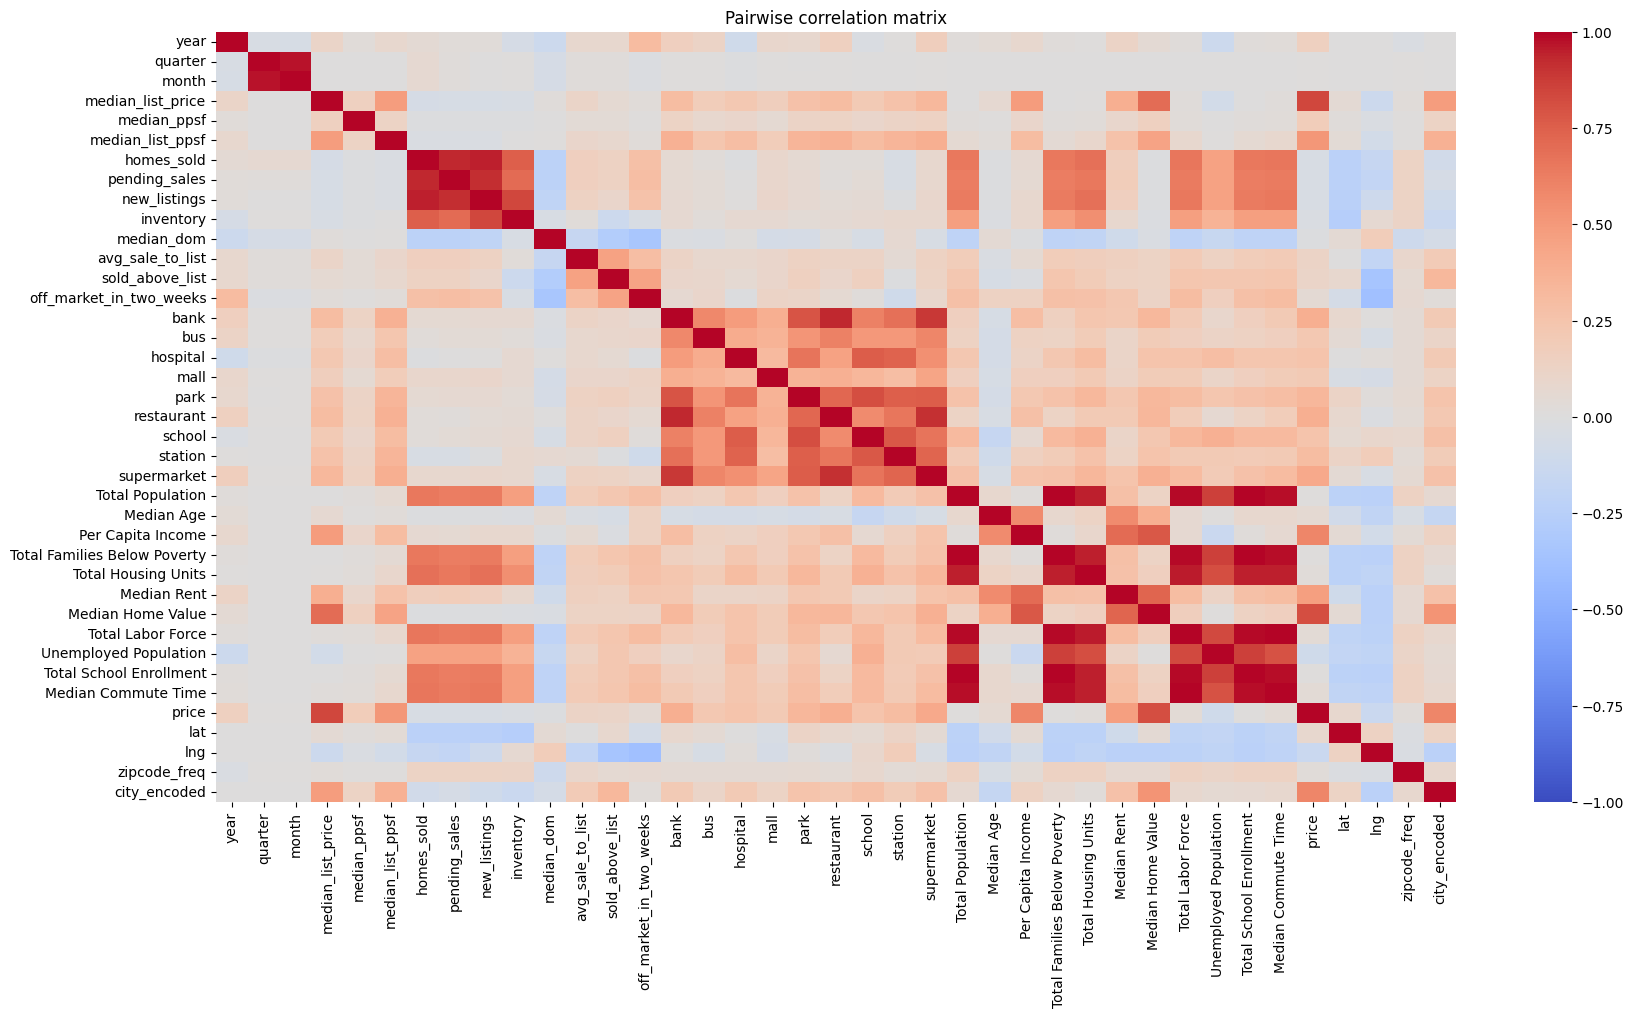

In [4]:
# Correlation Matrix

corr_matrix = df.corr().round(2)

# Visualizing the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pairwise correlation matrix")
plt.show()

In [5]:
# Variance Inflation Factor

def calculate_vif(df, target_col=None):
    """Calculate VIF for each numberic column in df"""

    # Keep numeric columns only
    numeric_df = df.select_dtypes(include=['float64', 'int64']).copy()

    # Drop target if provided
    if target_col and target_col in numeric_df.columns:
        numeric_df = numeric_df.drop(columns=[target_col])

    X = add_constant(numeric_df)

    # Calculate VIF for each feature
    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)

# Look at VIF 
vif_data = calculate_vif(df, target_col='price')
vif_data

,feature,VIF
0,const,1.097804e+06
1,Total Population,6.661307e+03
2,Total School Enrollment,5.462753e+03
3,Total Labor Force,8.377304e+02
4,Median Commute Time,6.506769e+02
5,Total Families Below Poverty,5.761353e+02
6,Total Housing Units,2.111765e+01
7,new_listings,2.033283e+01
8,quarter,1.741866e+01
9,month,1.737738e+01


- If VIF > 10 : Serious Multi-collinearity
- If VIF > 100: Drop the feature, it is catastrophic
- If VIF = inf: Perfect linear redundancy (drop one)

In [ ]:
# Ignoring the constant & Not removing the median commute time for now as it might be a proxy for distance from transport options.

problematic_columns = ['Total Population', "Total Labor Force", "Total Families Below Poverty", "Total School Enrollment"]
df[problematic_columns].corr()

# Also we need to keep in mind that tree based models are inherently good at navigating high collinearity. 
# Regularization also handles it well, where L1 drops redundant features and L2 shrinks those redundant coefficients. Elastic Net is very good for very high collinearity


,Total Population,Total Labor Force,Total Families Below Poverty,Total School Enrollment
Total Population,1.000000,0.985546,0.998984,0.999875
Total Labor Force,0.985546,1.000000,0.985533,0.986053
Total Families Below Poverty,0.998984,0.985533,1.000000,0.998734
Total School Enrollment,0.999875,0.986053,0.998734,1.000000


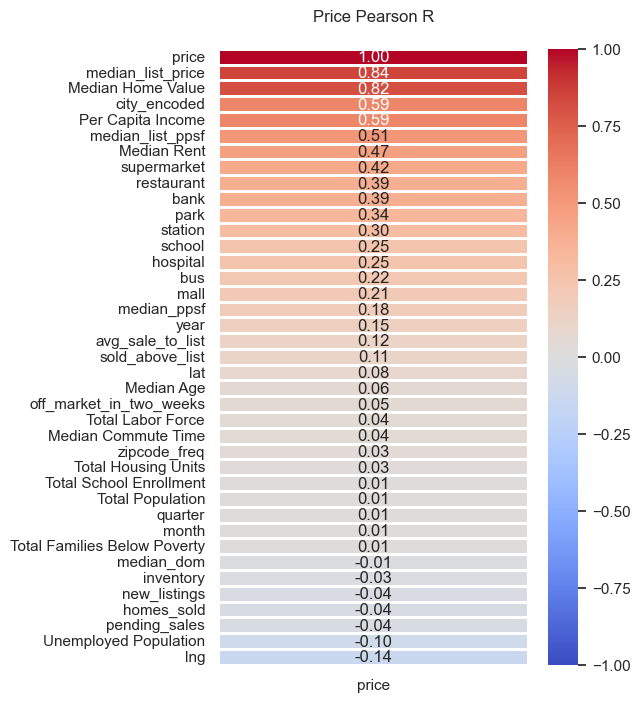

In [ ]:
# Compute correlation with price

num_cols = df.select_dtypes("number").columns
corr_vec = df[num_cols].corr(method="pearson")["price"].sort_values(ascending=False)
sns.set_theme(style="white")
plt.figure(figsize=(5,8))

ax = sns.heatmap(
    corr_vec.to_frame(),
    annot=True, fmt=".2f",
    vmin=-1, vmax=1,
    cmap="coolwarm",
    center=0,
    linewidth=1, linecolor="white",
)

ax.set_title("Price Pearson R", pad=20)
plt.show()

# We can infer that our offenders do not contribute anything to our target and at the same time hurt model stability by being highly multicollinear.
# We can also try to remove one of the two - median_list_price / Median Home Value

**Decision Flow**

High VIF 
   ↓
Low correlation with target?
   ↓ YES
Linear model + interpretability needed?
   ↓ YES → DROP
   ↓ NO -> Use regularization
Tree-based or regularized model?
   ↓ YES → KEEP or IGNORE VIF


### Mutual Information Scores

In [2]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, index=X.columns, name="MI Scores")
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = df.copy()
y = X.pop('price')

# MI works with numerical values only

mi_scores = make_mi_scores(X, y, discrete_features='auto')
mi_scores

# We can also infer that quarter & month has least effect on price. It can also be cross checked from the correlation plot. 
# However there can be interaction effect for these two.

median_list_price               1.562551
Median Home Value               1.408199
median_list_ppsf                1.015943
median_ppsf                     0.982241
Per Capita Income               0.883262
Median Rent                     0.808579
Total School Enrollment         0.577696
Total Population                0.577101
Total Housing Units             0.576610
Total Families Below Poverty    0.575929
Total Labor Force               0.568447
Median Commute Time             0.562652
Unemployed Population           0.491668
lat                             0.426609
lng                             0.426277
city_encoded                    0.425983
Median Age                      0.294791
school                          0.237570
park                            0.225983
restaurant                      0.183704
avg_sale_to_list                0.178005
bank                            0.155568
station                         0.149785
supermarket                     0.148472
zipcode_freq    

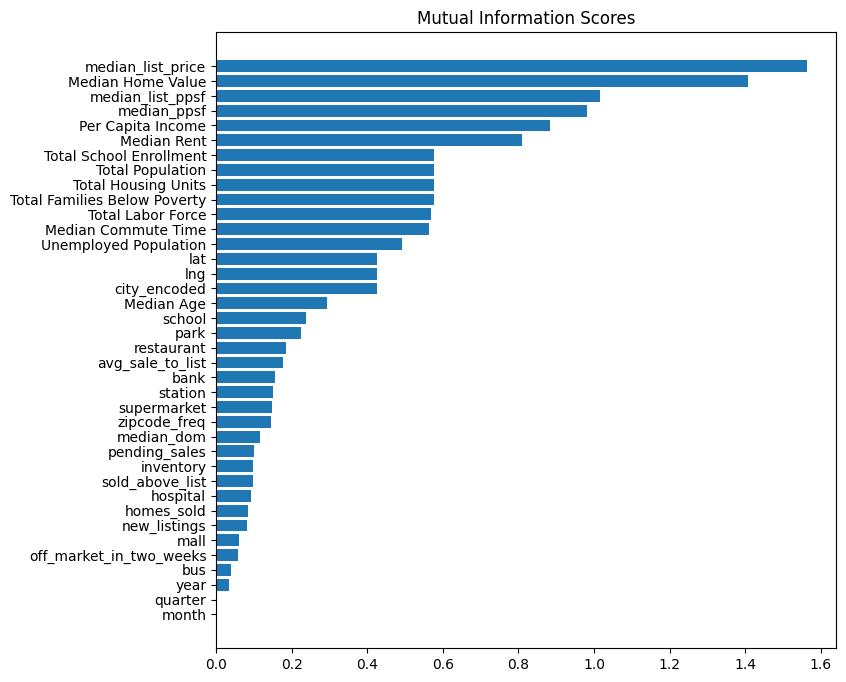

In [8]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 8))
plot_mi_scores(mi_scores)

### Clustering Based features

In [2]:
train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)
df = train_df

X = df.copy()
y = X.pop("price")

Approach to find the optimum k:

Method 1:  
For each candidate k:
- Subsample the data (e.g. 80%)

- Fit KMeans

- Repeat many times

- Measure assignment stability via Adjusted Rand Index (ARI)

- Measure variance explained

- Pick the smallest k with: High stability & Diminishing variance gains

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

features_for_clustering = ['bank', 'bus', 'hospital', 'mall', 'park',
       'restaurant', 'school', 'station', 'supermarket', 'Total Population',
       'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
       'Total Housing Units', 'Median Rent', 'Median Home Value', 'Median Commute Time']

# We want to select the features to answer "Which areas are fundamentally similar places to live?"
# We can also include lat and long if we want spatially similar areas in clusters.
# We should not mix structural variables with outcome variables 
# So the true latent factors we want clusters to recover are things like:

# Urban form
# Accessibility
# Socioeconomic base
# Demographic pressure
# Infrastructure density

# Not prices this month.

X_scaled = X.loc[:, features_for_clustering]
X_scaled = (X_scaled - X_scaled.mean(axis=0))/X_scaled.std(axis=0)


X_scaled.head()

,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Median Commute Time
0,0.071963,1.104470,-0.007090,-0.06383,0.204479,-0.022618,0.111123,-0.106072,-0.065461,-0.814242,-0.003972,0.028800,-0.806292,-0.802243,-0.727984,-0.027461,-0.823250
1,-0.402081,-0.398368,-0.473993,-0.44643,-0.605688,-0.326129,-0.717299,-0.343433,-0.526963,-0.987639,0.443803,-0.625163,-0.984764,-1.013067,-0.869256,-0.811208,-0.992236
2,-0.402081,-0.398368,-0.473993,-0.44643,-0.592186,-0.326129,-0.701668,-0.343433,-0.526963,-1.001531,0.932286,-0.701785,-0.999923,-0.993718,-0.897920,-0.946001,-1.016426
3,-0.362577,-0.398368,-0.473993,-0.44643,-0.605688,-0.312640,-0.654776,-0.343433,-0.526963,-1.091368,0.850872,-0.480904,-1.086868,-1.133998,-1.088330,-0.931589,-1.085098
4,-0.402081,-0.398368,-0.473993,-0.44643,-0.605688,-0.326129,-0.701668,-0.343433,-0.526963,-1.035284,0.712469,-0.707758,-1.030450,-1.068964,-1.190701,-0.876061,-1.035457


In [ ]:
def choose_k_stability(
        X,
        k_range=range(3, 13),
        n_bootstrap=30,
        sample_frac=0.8,
        random_state=42
):
    """
    Choose optimal K using clustering stability + variance explained.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Scaled feature matrix
    k_range : iterable
        Candidate values of K
    n_bootstrap : int
        Number of subsampling runs per K
    sample_frac : float
        Fraction of samples per subsample
    random_state : int

    Returns
    -------
    results : pd.DataFrame
    """ 

    rng = np.random.RandomState(random_state)
    
    # Baseline SSE for k=1 (Variance Explained)
    kmeans_1 = KMeans(n_clusters=1, n_init=10, random_state=random_state)
    kmeans_1.fit(X)
    sse_1 = kmeans_1.inertia_

    records = []

    for run_number, k in enumerate(k_range):
        labels_list = []
        inertia_list = []

        for i in range(n_bootstrap):
            X_sub, idx = resample(
                X, 
                np.arange(len(X)), 
                n_samples=int(sample_frac * len(X)), 
                random_state=rng.randint(0, 10000)
            )
            
            km = KMeans(n_clusters=k, n_init=10, random_state=rng.randint(0, 10000))
            km.fit(X_sub)

            # Store as a dictionary mapping index -> label
            label_dict = dict(zip(idx, km.labels_))
            labels_list.append(label_dict)
            inertia_list.append(km.inertia_)

        # Stability: Pairwise ARI
        ari_scores = []
        for i in range(len(labels_list)):
            for j in range(i + 1, len(labels_list)):
                dict_i = labels_list[i]
                dict_j = labels_list[j]

                # Find common keys (sample indices)
                common = set(dict_i.keys()) & set(dict_j.keys())

                if len(common) < 10:
                    continue

                # Extract labels in the same order
                common_sorted = sorted(common)
                li = [dict_i[idx] for idx in common_sorted]
                lj = [dict_j[idx] for idx in common_sorted]

                ari_scores.append(adjusted_rand_score(li, lj))
        
        stability = np.mean(ari_scores) if ari_scores else 0

        # Variance Explained
        mean_sse = np.mean(inertia_list)
        variance_explained = 1 - mean_sse / sse_1

        records.append({
            "k": k,
            "stability_ari": stability,
            "variance_explained": variance_explained
        })
    
        print(f"Run {run_number+1}: Completed the computation for k = {k}")    
        
    return pd.DataFrame(records)

In [26]:
# Run experiments
results = choose_k_stability(
    X_scaled,
    k_range=range(5,13),
    n_bootstrap=20
)
print()
print(results)

Run 1: Completed the computation for k = 5
Run 2: Completed the computation for k = 6
Run 3: Completed the computation for k = 7
Run 4: Completed the computation for k = 8
Run 5: Completed the computation for k = 9
Run 6: Completed the computation for k = 10
Run 7: Completed the computation for k = 11
Run 8: Completed the computation for k = 12

    k  stability_ari  variance_explained
0   5       0.989224            0.626709
1   6       0.993073            0.662437
2   7       0.992583            0.687722
3   8       0.988996            0.710582
4   9       0.970880            0.725643
5  10       0.989149            0.740284
6  11       0.961900            0.750458
7  12       0.947933            0.759406


- As the number of clusters increase, explained variance goes up as expected.
- The stability is highest for the cluster size of 6, if we want to increase the explained variance then we can go at higher cluster size.
- If we go for higher cluster size, We can say that the stability reduces after cluster size of 10 with minimal increment in variance, hence we can take our optimum number of clusters to be 10. 
- Overall we can go with 6 or 10 clusters depending on requirement

Method 2:  
Silhoutte Method

In [7]:
# Confirming this with the silhoutte score method - Although it is slightly biased towards a smaller k


# Silhoutte score works on O(n2) complexity and it will choke the CPU for 580k samples. 
# Hence we take a small sample and compute silhoutte score on that. We also use the other alternatives.

In [19]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

def fast_silhouette(X, labels, sample_size=100000, random_state=42):
    """Calculate silhouette score on a random sample."""
    if len(X) <= sample_size:
        return silhouette_score(X, labels)
    
    rng = np.random.RandomState(random_state)
    idx = rng.choice(len(X), size=sample_size, replace=False)
    
    return silhouette_score(X.iloc[idx], labels[idx])

scores = []
for k in range(4, 13):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Both are very fast even on large datasets
    ch_score = calinski_harabasz_score(X_scaled, labels)  # Higher is better
    db_score = davies_bouldin_score(X_scaled, labels)      # Lower is better

    # Silhoutte score on randomly selected batch of 10000
    sil_score = fast_silhouette(X_scaled, labels)

    scores.append({
                "k": k,
                "fast_silhoutte_score": sil_score,
                "calinski_harabasz_score": ch_score,
                "davies_bouldin_score": db_score
            })
    
print()
print(pd.DataFrame(scores))


    k  fast_silhoutte_score  calinski_harabasz_score  davies_bouldin_score
0   4              0.306187            176663.175585              1.146113
1   5              0.307828            165293.919994              1.330889
2   6              0.295109            158756.047501              1.279001
3   7              0.292332            150561.705760              1.386002
4   8              0.264087            145997.326157              1.337174
5   9              0.270405            138583.103039              1.309488
6  10              0.272254            133982.784378              1.336031
7  11              0.248577            127731.132713              1.381977
8  12              0.247626            122523.321410              1.385756


The above values seem to favor cluster size of 4, but does not take into account percentage of variance explained

Method 3:  
Elbow Method

In [20]:
# Checking with the elbow method as well
def elbow_method(X, k_range=range(2, 15), random_state=42):
    """
    Elbow method with automatic elbow point detection using the kneed library.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Scaled feature matrix
    k_range : iterable
        Candidate values of K
    random_state : int
    
    Returns
    -------
    results : pd.DataFrame
    optimal_k : int
    """
    
    # Convert to numpy if DataFrame
    if hasattr(X, 'values'):
        X = X.values
    
    inertias = []
    
    for k in k_range:
        print(f"Fitting k={k}...")
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        km.fit(X)
        inertias.append(km.inertia_)
    
    results = pd.DataFrame({
        'k': list(k_range),
        'inertia': inertias
    })
    
    # Use kneed library to find the optimal point
    try:
        from kneed import KneeLocator
        
        kneedle = KneeLocator(
            list(k_range), 
            inertias, 
            curve='convex', 
            direction='decreasing'
        )
        optimal_k_kneed = kneedle.elbow
    except ImportError:
        print("Install kneed library for automatic detection: pip install kneed")
        optimal_k_kneed = None

    return results, optimal_k_kneed


def plot_elbow(results, optimal_k_kneed=None):
    """
    Plot the elbow curve with optimal k marked.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Raw inertia
    ax1 = axes[0]
    ax1.plot(results['k'], results['inertia'], 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inertia (Within-cluster SSE)', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    if optimal_k_kneed:
        ax1.axvline(x=optimal_k_kneed, color='r', linestyle='--', 
                    label=f'Kneed optimal: k={optimal_k_kneed}')
    ax1.legend()
    
    # Plot 2: Normalized inertia (percentage of variance explained)
    ax2 = axes[1]
    max_inertia = results['inertia'].max()
    variance_explained = 1 - (results['inertia'] / max_inertia)
    
    ax2.plot(results['k'], variance_explained * 100, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Variance Explained (%)', fontsize=12)
    ax2.set_title('Variance Explained by Clusters', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    if optimal_k_kneed:
        ax2.axvline(x=optimal_k_kneed, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()
    
    return fig

In [21]:
elbow_results = elbow_method(X_scaled)

Fitting k=2...
Fitting k=3...
Fitting k=4...
Fitting k=5...
Fitting k=6...
Fitting k=7...
Fitting k=8...
Fitting k=9...
Fitting k=10...
Fitting k=11...
Fitting k=12...
Fitting k=13...
Fitting k=14...


In [22]:
print("Optimal cluster size based on elbow method: ", elbow_results[1])

Optimal cluster size based on elbow method:  6


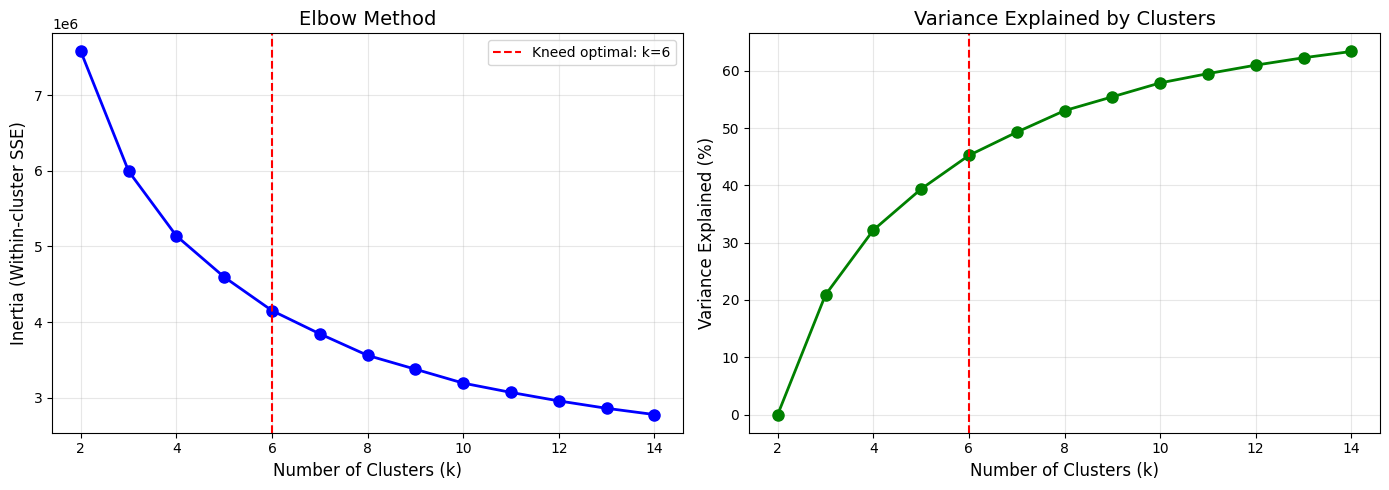

In [24]:
figure = plot_elbow(elbow_results[0], elbow_results[1])

Based on combined assessment, we can go ahead with 10 clusters for better stability and more variance.  
  
We will also use cluster distance based features instead of labels for better semantic information about the clusters, which will help the model to perform better. 

**Creating the cluster features**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

features_for_clustering = ['bank', 'bus', 'hospital', 'mall', 'park',
       'restaurant', 'school', 'station', 'supermarket', 'Total Population',
       'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
       'Total Housing Units', 'Median Rent', 'Median Home Value', 'Median Commute Time']

train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)
dev_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev.csv", index_col=0)
test_df= pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_test.csv", index_col=0)

In [6]:
train_df[features_for_clustering].head()

,bank,bus,hospital,mall,park,restaurant,school,station,supermarket,Total Population,Median Age,Per Capita Income,Total Families Below Poverty,Total Housing Units,Median Rent,Median Home Value,Median Commute Time
0,12.0,2.0,4.0,1.0,60.0,45.0,57.0,4.0,7.0,5811.0,36.3,33052.0,5811.0,2677.0,710.0,279500.0,2492.0
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2441.0,41.8,20241.0,2385.0,1108.0,641.0,94600.0,1018.0
2,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,2171.0,47.8,18740.0,2094.0,1252.0,627.0,62800.0,807.0
3,1.0,0.0,0.0,0.0,0.0,2.0,8.0,0.0,0.0,425.0,46.8,23067.0,425.0,208.0,534.0,66200.0,208.0
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1515.0,45.1,18623.0,1508.0,692.0,484.0,79300.0,641.0


In [5]:
n_clusters = 10

cluster_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(
            n_clusters=n_clusters,
            random_state=42,
            n_init=10
        ))
    ]
)


In [7]:
# Fit on train

cluster_pipeline.fit(train_df[features_for_clustering])

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('kmeans', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",10
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final

In [ ]:
# Creating cluster based features using cluster distances to get continuous, richer and semantic features
# Including the cluster labels as well as they often provide a slight improvement in performance in tree based models. Not helpful for linear models as semantic information is already present.

def add_cluster_distances_and_labels(X, pipeline, feature_cols, prefix="cluster"):
    scaler = pipeline.named_steps["scaler"]
    kmeans = pipeline.named_steps["kmeans"]

    X_scaled = scaler.transform(X[feature_cols])
    distances = kmeans.transform(X_scaled)
    labels = kmeans.predict(X_scaled)

    X_out = X.copy()
    for i in range(distances.shape[1]):
        X_out[f"{prefix}_dist_{i+1}"] = distances[:, i]

    X_out["cluster_label"] = labels
    
    return X_out


In [16]:
X_train = add_cluster_distances_and_labels(train_df, cluster_pipeline, features_for_clustering)
X_dev  = add_cluster_distances_and_labels(dev_df,  cluster_pipeline, features_for_clustering)
X_test  = add_cluster_distances_and_labels(test_df,  cluster_pipeline, features_for_clustering)

In [19]:
X_train.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train_with_clustering.csv")
X_dev.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev_with_clustering.csv")
X_test.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_test_with_clustering.csv")

### Principal Component Analysis (PCA)

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)
dev_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev.csv", index_col=0)
test_df= pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_test.csv", index_col=0)

In [3]:
train_df.columns

Index(['year', 'quarter', 'month', 'median_list_price', 'median_ppsf',
       'median_list_ppsf', 'homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks', 'bank', 'bus', 'hospital', 'mall', 'park',
       'restaurant', 'school', 'station', 'supermarket', 'Total Population',
       'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
       'Total Housing Units', 'Median Rent', 'Median Home Value',
       'Total Labor Force', 'Unemployed Population', 'Total School Enrollment',
       'Median Commute Time', 'price', 'lat', 'lng', 'zipcode_freq',
       'city_encoded'],
      dtype='object')

In [4]:
# Market dynamics based features
MARKET_DYNAMICS = ['homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks']

# Price and valuation based features (We do have multicollinear features here, hence PCA might help)
PRICE_STRUCTURE = ['median_list_price', 'median_ppsf',
       'median_list_ppsf', 'Median Home Value', 'Median Rent']

# Socioeconomic status based features
SOCIOECONOMIC = ['Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
                         'Total Labor Force', 'Unemployed Population', 'Total School Enrollment', 'Median Commute Time']

# ---- Non-PCA features (used directly) ----
DIRECT_FEATURES = [
    "year", "quarter", "month",
    "lat", "lng",
    "Total Housing Units",
    "bank", "bus", "hospital", "mall", "park",
    "restaurant", "school", "station", "supermarket",
]

We are choosing features this way becuase these groups reflect different data-generating process. Joint PCA would mix market liquidity variance, income variance and price sale variance.  

In the first group, the principal components might represent:  
- PC1: market heat / liquidity
- PC2: supply vs demand imbalance
- PC3: transaction friction

In the second group, the principal components will help in stabilizing linear models due to multicollinearity in features.  

In the third group, the principal components might represent:  
- PC1: economic prosperity
- PC2: workforce vs dependents
- PC3: urban stress/congestion

In [5]:
# Pipeline 
def make_pca_pipeline(n_components):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, random_state=42))
    ])

pca_market = make_pca_pipeline(n_components=3)
pca_price  = make_pca_pipeline(n_components=2)
pca_socio  = make_pca_pipeline(n_components=3)

# ---- Fit on TRAIN ----
X_train_market = pca_market.fit_transform(train_df[MARKET_DYNAMICS])
X_train_price  = pca_price.fit_transform(train_df[PRICE_STRUCTURE])
X_train_socio  = pca_socio.fit_transform(train_df[SOCIOECONOMIC])


In [6]:
# ---- DEV ----
X_dev_market = pca_market.transform(dev_df[MARKET_DYNAMICS])
X_dev_price  = pca_price.transform(dev_df[PRICE_STRUCTURE])
X_dev_socio  = pca_socio.transform(dev_df[SOCIOECONOMIC])

# ---- TEST ----
X_test_market = pca_market.transform(test_df[MARKET_DYNAMICS])
X_test_price  = pca_price.transform(test_df[PRICE_STRUCTURE])
X_test_socio  = pca_socio.transform(test_df[SOCIOECONOMIC])

In [7]:
def pca_df(X_pca, prefix, index):
    return pd.DataFrame(
        X_pca,
        columns=[f"{prefix}_PC{i+1}" for i in range(X_pca.shape[1])],
        index=index
    )

# ---- TRAIN ----
train_pca_df = pd.concat([
    pca_df(X_train_market, "market", train_df.index),
    pca_df(X_train_price,  "price",  train_df.index),
    pca_df(X_train_socio,  "socio",  train_df.index)
    # train_df[DIRECT_FEATURES]
], axis=1)

# ---- DEV ----
dev_pca_df = pd.concat([
    pca_df(X_dev_market, "market", dev_df.index),
    pca_df(X_dev_price,  "price",  dev_df.index),
    pca_df(X_dev_socio,  "socio",  dev_df.index)
    # dev_df[DIRECT_FEATURES]
], axis=1)

# ---- TEST ----
test_pca_df = pd.concat([
    pca_df(X_test_market, "market", test_df.index),
    pca_df(X_test_price,  "price",  test_df.index),
    pca_df(X_test_socio,  "socio",  test_df.index)
    # test_df[DIRECT_FEATURES]
], axis=1)



In [41]:
dev_pca_df.head()

,market_PC1,market_PC2,market_PC3,price_PC1,price_PC2,socio_PC1,socio_PC2,socio_PC3
0,-1.104284,0.317975,-0.525109,-0.768235,0.013809,-1.303032,0.171461,0.523020
1,-0.097237,0.481749,-1.022459,-1.052713,0.076365,-0.267806,-0.021680,-0.003681
2,2.825290,-3.519359,1.562456,7.378086,0.589453,4.961782,3.834219,-3.231214
3,-1.748382,-0.558094,0.109188,0.973317,-0.157798,-2.028803,1.598114,0.164922
4,-1.300145,1.140365,-0.492867,-0.568980,0.097585,-2.009386,0.086657,0.290300


In [44]:
def plot_variance(pca_pipeline, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca_pipeline['pca'].n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca_pipeline["pca"].explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

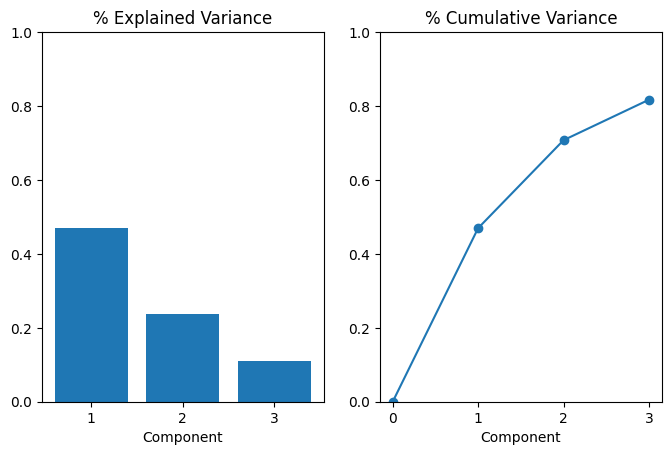

In [45]:
plot_variance(pca_market)

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

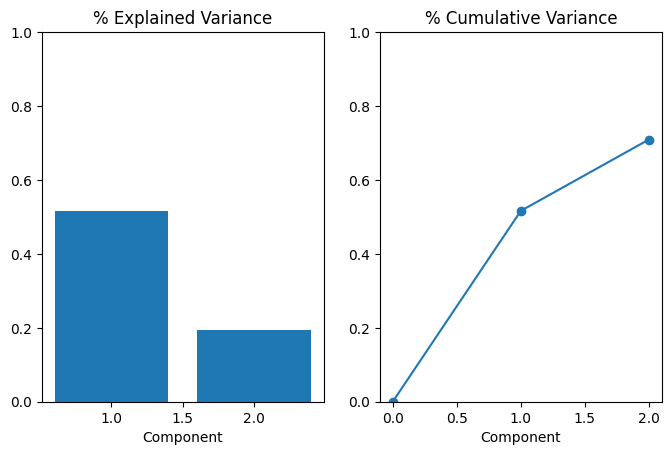

In [46]:
plot_variance(pca_price)

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

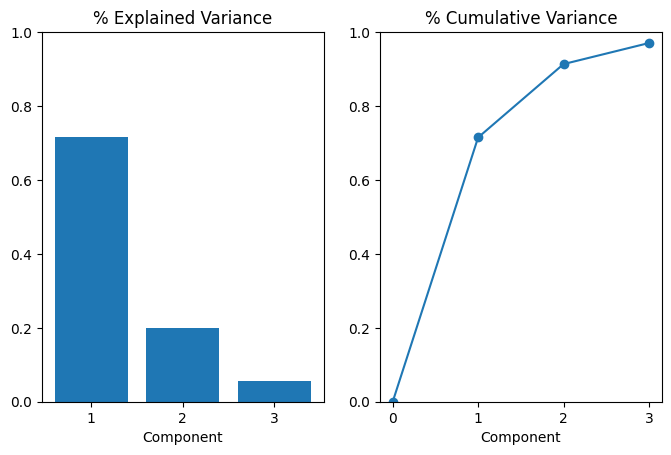

In [47]:
plot_variance(pca_socio)

In [8]:
X = train_df.copy()
y = X.pop('price')

# MI works with numerical values only

mi_scores_pca = make_mi_scores(train_pca_df, y, discrete_features='auto')
mi_scores_pca

price_PC1     1.262162
socio_PC3     0.811502
socio_PC2     0.745690
socio_PC1     0.587246
price_PC2     0.348911
market_PC3    0.128610
market_PC2    0.122548
market_PC1    0.116272
Name: MI Scores, dtype: float64

In [9]:
def pca_loadings(pipe, feature_names, prefix):
    return pd.DataFrame(
        pipe.named_steps["pca"].components_.T,
        index=feature_names,
        columns=[f"{prefix}_PC{i+1}" 
                 for i in range(pipe.named_steps["pca"].n_components_)]
    )

market_loadings = pca_loadings(pca_market, MARKET_DYNAMICS, "market")
price_loadings  = pca_loadings(pca_price,  PRICE_STRUCTURE, "price")
socio_loadings  = pca_loadings(pca_socio,  SOCIOECONOMIC, "socio")


In [10]:
market_loadings

,market_PC1,market_PC2,market_PC3
homes_sold,0.494904,-0.088444,0.003379
pending_sales,0.488342,-0.078534,-0.004111
new_listings,0.499363,-0.132642,0.015544
inventory,0.409122,-0.323911,0.107209
median_dom,-0.164662,-0.348588,0.717723
avg_sale_to_list,0.137185,0.439869,0.616340
sold_above_list,0.121168,0.566473,0.212575
off_market_in_two_weeks,0.198073,0.477083,-0.219193


In [11]:
price_loadings

,price_PC1,price_PC2
median_list_price,0.509356,-0.016960
median_ppsf,0.162641,0.963776
median_list_ppsf,0.407810,0.070444
Median Home Value,0.573954,-0.126059
Median Rent,0.467303,-0.223595


In [12]:
socio_loadings

,socio_PC1,socio_PC2,socio_PC3
Total Population,0.416694,-0.005881,-0.017879
Median Age,0.035705,0.693604,0.699853
Per Capita Income,0.011173,0.709365,-0.627491
Total Families Below Poverty,0.416568,-0.003812,-0.015603
Total Labor Force,0.413994,0.018093,-0.113034
Unemployed Population,0.371012,-0.121476,0.289338
Total School Enrollment,0.416677,-0.002263,-0.018917
Median Commute Time,0.410825,0.024023,-0.138011


In [13]:
train_pca_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/train_pca_features.csv")
dev_pca_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/dev_pca_features.csv")
test_pca_df.to_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/test_pca_features.csv")